In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
# from numpy import infinity
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib .patches import Patch, Rectangle
from shapely.geometry import Point
from shapely.geometry import LineString

commute = pd.read_csv(r"../data/sodb_2021_dochadzka_denne_lm_rk.csv", encoding="windows-1250")
obce = gpd.read_file(r"../data/liptov_obce.csv", encoding = "windows-1250")
map2 = gpd.read_file(r"../data/geo/liptov.shp")
lipt_colors = pd.read_csv(r"../data/colors.csv", sep=";")
map2.drop(columns = ["DOW", "FACC", "IDN3", "NM3", "IDN2", "NM2", "NUTS1", "NUTS1_CODE", "NUTS2", "NUTS2_CODE", "NUTS3", "NUTS3_CODE", "LAU1", "LAU1_CODE", "LAU2", "LAU2_CODE", "VYMERA", "Shape_Area", "Shape_Leng"], inplace = True)

commute[["obecA", "obecB"]] = commute[["obecA", "obecB"]].astype(str)
commute["pocet"] = commute["pocet"].astype(int)
lipt_colors["obec_id"] = lipt_colors["obec_id"].astype(str)
map2["IDN4"] = map2["IDN4"].astype(str)
obce["kod"] = obce["kod"].astype(str)

     obecA  spolu  mimo_obce  v_obci  mimo_obce_percent  v_obci_percent  \
0   507300    149        131    18.0          87.919463       12.080537   
1   507393     55         53     2.0          96.363636        3.636364   
2   507407     47         42     5.0          89.361702       10.638298   
3   510262   6561       1380  5181.0          21.033379       78.966621   
4   510271    141        135     6.0          95.744681        4.255319   
..     ...    ...        ...     ...                ...             ...   
76  511196    243        192    51.0          79.012346       20.987654   
77  511200    116        106    10.0          91.379310        8.620690   
78  556807     17         17     0.0         100.000000        0.000000   
79  558281    226        200    26.0          88.495575       11.504425   
80  580287    306        295    11.0          96.405229        3.594771   

    independence  
0          False  
1          False  
2          False  
3           True  
4   

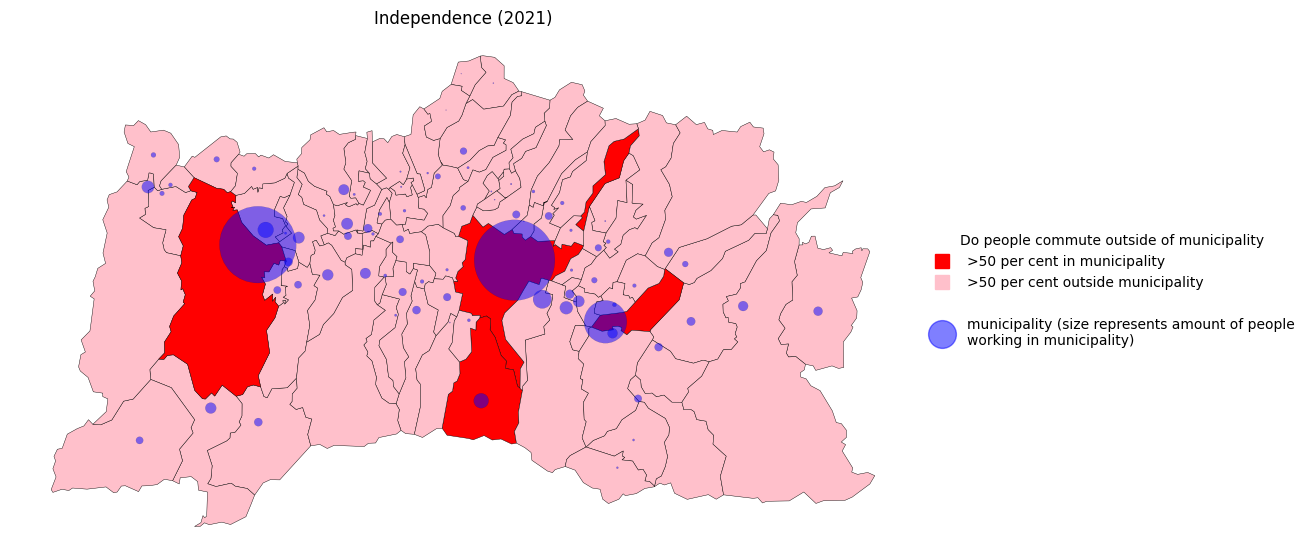

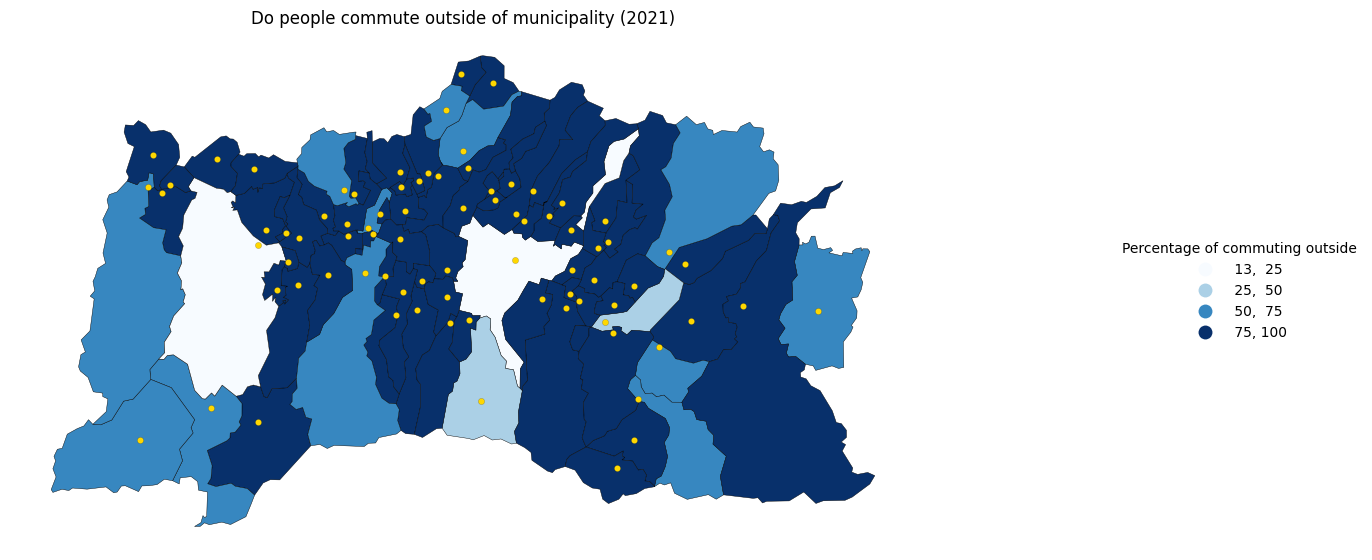

In [3]:
all = (
    commute
    .groupby("obecA", group_keys = False)["pocet"]
    .sum()
)
outer = (
    commute[commute["obecA"] != commute["obecB"]]
    .groupby("obecA", group_keys=False)["pocet"]
    .sum()
)
inter = (
    commute[commute["obecA"] == commute["obecB"]]
    .groupby("obecA", group_keys=False)["pocet"]
    .sum()
)

all_df = all.reset_index().rename(columns = {"pocet": "spolu"})
inter_df = inter.reset_index().rename(columns = {"pocet": "v_obci"})
outer_df = outer.reset_index().rename(columns = {"pocet": "mimo_obce"})

table = all_df.merge(
    outer_df.merge(
    inter_df,
    on = "obecA",
    how = "left"
), on = "obecA", how = "left").fillna(0)
# print(outer.head())
# print(inter)

table["mimo_obce_percent"] = table["mimo_obce"]/table["spolu"]*100
table["v_obci_percent"] = table["v_obci"]/table["spolu"]*100
table["independence"] = table["v_obci"] > table["mimo_obce"]
print(table)
tablemap2 = map2.merge(
    table,
    left_on = "IDN4",
    right_on = "obecA",
    how = "left"
)

# print(tablemap2)
color_dict_i = {True: "red", False: "pink"}
# print(obce.head())
comm = (commute.groupby("obecB", group_keys = False)["pocet"].sum())
comm = comm.reset_index()
# print(comm.head())
obce_comm = obce.merge(
    comm,
    left_on = "kod",
    right_on = "obecB",
    how = "left"
)
# print(obce_comm.head())

obce_gdf = gpd.GeoDataFrame(
    obce_comm,
    geometry=[Point(xy) for xy in zip(obce["x"], obce["y"])],
    crs="EPSG:5514"
)
# print(obce_gdf.head())
independence_bins = [25, 50, 75]
# ---------------- DOES THE MAJORITY OF PEOPLE IN WORKING AGE COMMUTE OUTSIDE OF MUNICIPALITY ---------------- 
plt.figure(figsize = (11.69, 8.27))
# plt.subplot(2, 1, 1)
tablemap2.plot(
    ax = plt.gca(),
    color = tablemap2["independence"].map(color_dict_i),
    edgecolor = "black",
    linewidth = 0.3
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "blue",
    markersize = obce_gdf["pocet"]/obce_gdf["pocet"].idxmax()*20,
    alpha = 0.5,
    edgecolor = "black",
    linewidth = 0.1
)
handles_i = [
    plt.Line2D(
        [0], [0],
        marker = "s",
        markersize = 10,
        linestyle = "None",
        color = color,
        # edgecolor = "black",
        label = ">50 per cent in municipality" if key else ">50 per cent outside municipality"
        )
        for key, color in color_dict_i.items()
]
handles_i.append(
    plt.Line2D(
        [0], [0],
        marker = "",
        color = "white",
        markersize = 20,
        linestyle = "None",
        label = ""
    )
)
handles_i.append(
    plt.Line2D(
        [0], [0],
        marker = "o",
        color = "blue",
        alpha = 0.5,
        markersize = 20,
        linestyle = "None",
        label = "municipality (size represents amount of people\nworking in municipality)"
    )
)
plt.legend(
    handles = handles_i,
    title = "Do people commute outside of municipality",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False
)

plt.title("Independence (2021)")
plt.axis(False)
# plt.savefig("../result_maps/autonomy/LM_RK_autonomy_2021_binary.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()
# ---------------- WHICH PERCENT OF PEOPLE DOES COMMUTE OUTSIDE OF MUNICIPALITY ---------------- 
plt.figure(figsize = (11.69, 8.27))
tablemap2["interval"] = pd.cut(tablemap2["mimo_obce_percent"], bins = independence_bins, labels = False)
# plt.subplot(2, 1, 2)
tablemap2.plot(
    ax = plt.gca(),
    column = "mimo_obce_percent",
    cmap = "Blues",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "user_defined",
    classification_kwds = {"bins": independence_bins},
    legend_kwds = {
        "title": "Percentage of commuting outside",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 20.0,
    edgecolor = "black",
    linewidth = 0.1
)
plt.title("Do people commute outside of municipality (2021)")
plt.axis(False)
plt.savefig("../result_maps/autonomy/LM_RK_autonomy_2021.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

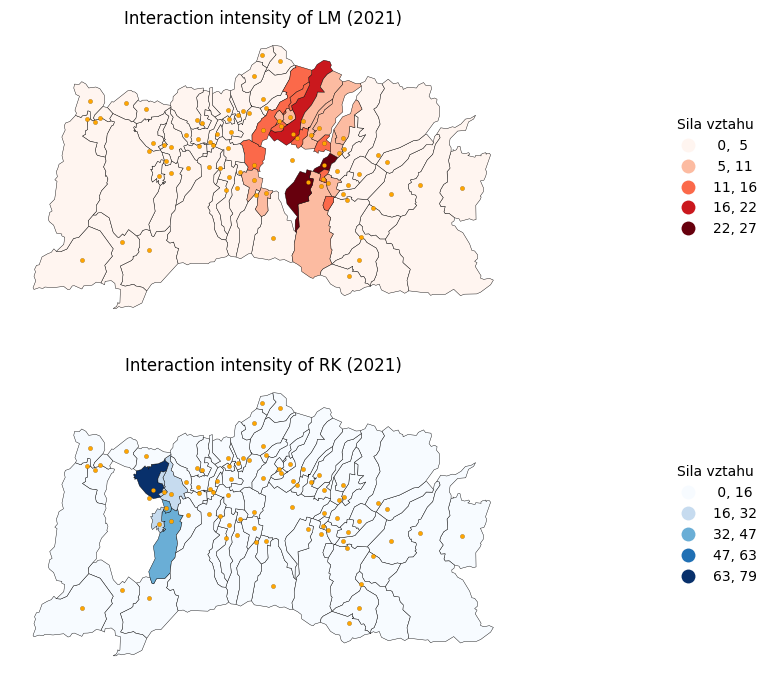

In [4]:
distance = pd.read_csv(r"../data/vzdialenost_obce.csv", sep = ";")
# print(distance)
distance[["obec_id", "mesto_id"]] = distance[["obec_id", "mesto_id"]].astype(str)
dist = tablemap2.merge(
    distance,
    left_on = "obecA",
    right_on = "obec_id",
    how = "right" 
)
dist = dist[dist["obec_id"] != dist["mesto_id"]]

# print(dist.head())
dist["strength"] = ((dist["pocet_dochadzajucich"]/dist["spolu"]*100)/dist["vzdialenost_km"]**2)*10
# dist.to_csv("../data/test1.csv")
dist_lm = (
    dist[dist["mesto_id"] == "510262"]
).replace(np.inf, 0, inplace = False)
dist_rk = (
    dist[dist["mesto_id"] == "510998"]
).replace(np.inf, 0, inplace = False)
# print(dist_rk)
plt.figure(figsize = (11.69, 8.27))
# ------------------------------ Gravity force of LM ------------------------------
plt.subplot(2, 1, 1)
dist_lm["interval"] = pd.cut(dist_lm["strength"], bins = 5, labels = False)
dist_lm.plot(
    ax = plt.gca(),
    column = "strength",
    cmap = "Reds",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "equalinterval",
    k = 5,
    legend_kwds = {
        "title": "Sila vztahu",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "orange",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
plt.title("Interaction intensity of LM (2021)")
plt.axis(False)

# ------------------------------ Gravity force of RK ------------------------------
plt.subplot(2, 1, 2)
dist_rk["interval"] = pd.cut(dist_rk["strength"], bins = 5, labels = False)
dist_rk.plot(
    ax = plt.gca(),
    column = "strength",
    cmap = "Blues",
    legend = True,
    edgecolor = "black",
    linewidth = 0.3,
    scheme = "equalinterval",
    k = 5,
    legend_kwds = {
        "title": "Sila vztahu",
        "loc": "right",
        "fmt": "{:.0f}",
        "frameon": False,
        "bbox_to_anchor": (1.5, 0.5)
    }
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "orange",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
plt.title("Interaction intensity of RK (2021)")
plt.axis(False)
# plt.savefig("../result_maps/gravity/LM_RK_gravity_2021.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

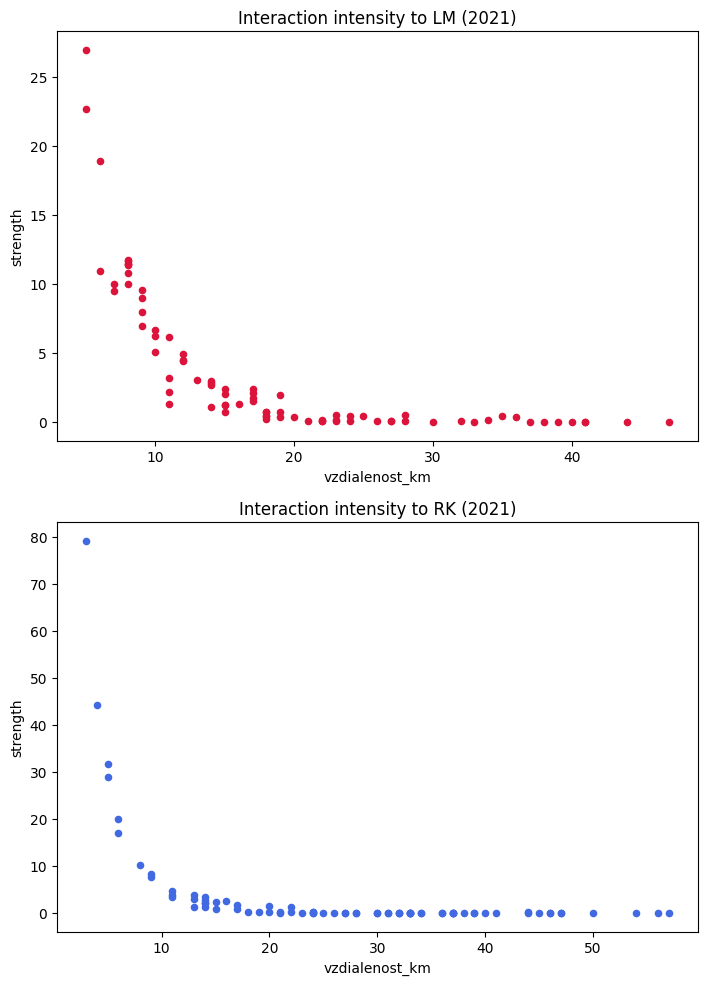

In [5]:
plt.figure(figsize = (8.27, 11.69))

plt.subplot(2, 1, 1)
dist_lm.plot(kind = "scatter", x = "vzdialenost_km", y = "strength", ax = plt.gca(), color = "crimson")
plt.title("Interaction intensity to LM (2021)")
plt.subplot(2, 1, 2)

dist_rk.plot(kind = "scatter", x = "vzdialenost_km", y = "strength", ax = plt.gca(), color = "royalblue")

plt.title("Interaction intensity to RK (2021)")
# plt.savefig("../result_maps/gravity/LM_RK_gravity_2021_plot.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

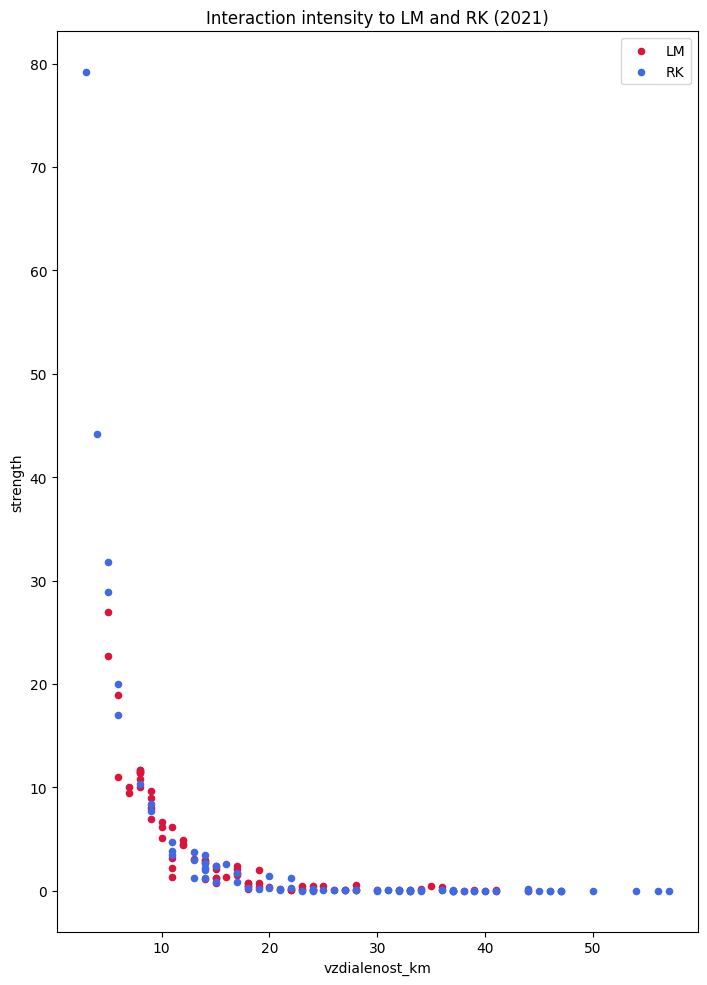

In [6]:
plt.figure(figsize = (8.27, 11.69))

dist_lm.plot(kind = "scatter", x = "vzdialenost_km", y = "strength", ax = plt.gca(), color = "crimson", label = "LM")
plt.title("Gravity force strength to LM (2021)")

dist_rk.plot(kind = "scatter", x = "vzdialenost_km", y = "strength", ax = plt.gca(), color = "royalblue", label = "RK")
plt.title("Interaction intensity to LM and RK (2021)")
# plt.savefig("../result_maps/gravity/LM_RK_gravity_2021_plot_both.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

In [7]:
# Most popular destinations (part 1)

commuting = pd.read_csv(r"../data/sodb_2021_dochadzka_denne_lm_rk.csv", encoding="windows-1250")
map = gpd.read_file(r"../data/geo/liptov.shp")
okresy = gpd.read_file(r"../data/geo/liptov_okresy.shp")


commuting[["obecA", "obecB"]] = commuting[["obecA", "obecB"]].astype(str)
map["IDN4"] = map["IDN4"].astype(str)
commuting = commuting.merge(
    lipt_colors,
    left_on = "obecB",
    right_on = "obec_id",
    how = "left"
)
most_popular = (
    commuting[commuting["obecA"] != commuting["obecB"]]
    .groupby("obecA", group_keys = False)[["obecA", "obecB", "obecB_nazov", "pocet", "color"]]
    .apply(lambda x: x.loc[x["pocet"].idxmax()])
    .reset_index(drop = True)
)

result = map.merge(
    most_popular[["obecA", "obecB", "obecB_nazov", "color"]],
    left_on = "IDN4",
    right_on = "obecA",
    how = "left"
).rename(columns={"IDN4": "kod_start"})
unique_dest = result[["obecB_nazov", "color"]].drop_duplicates()
legend_patches1 = [
    mpatches.Patch(color = row["color"], label = row["obecB_nazov"])
    for _, row in unique_dest.iterrows()
]

most_popular2 = (
    commuting
    .groupby("obecA", group_keys = False)[["obecA", "obecB", "obecB_nazov", "pocet", "color"]]
    .apply(lambda x: x.loc[x["pocet"].idxmax()])
    .reset_index(drop = True)
)

result2 = map.merge(
    most_popular2[["obecA", "obecB", "obecB_nazov", "color"]],
    left_on = "IDN4",
    right_on = "obecA",
    how = "left"
).rename(columns={"IDN4": "kod_start"})
unique_dest2 = result2[["obecB_nazov", "color"]].drop_duplicates()
legend_patches2 = [
    mpatches.Patch(color = row["color"], label = row["obecB_nazov"])
    for _, row in unique_dest2.iterrows()
]


second_popular_50 = (
    commuting[commuting["obecA"] != commuting["obecB"]]
    .groupby("obecA", group_keys = False)[["obecA", "obecB", "obecB_nazov", "pocet", "color"]]
    .apply(lambda x: x.nlargest(2, "pocet").iloc[-1] if len(x) > 1 and x.nlargest(2, "pocet")["pocet"].iloc[1] >= x.nlargest(2, "pocet")["pocet"].iloc[0] * 0.5 else None)
    .reset_index(drop=True)
).dropna()
result3 = map.merge(
    second_popular_50[["obecA", "obecB", "obecB_nazov", "color"]],
    left_on = "IDN4",
    right_on = "obecA",
    how = "left"
).rename(columns = {"IDN4": "kod_start"})
unique_dest3 = result3[["obecB_nazov", "color"]].drop_duplicates()
unique_dest3["color"] = result3["color"].fillna("lightgray")
legend_patches3 = [
    mpatches.Patch(color = row["color"], label = row["obecB_nazov"])
    for _, row in unique_dest3.iterrows()
]

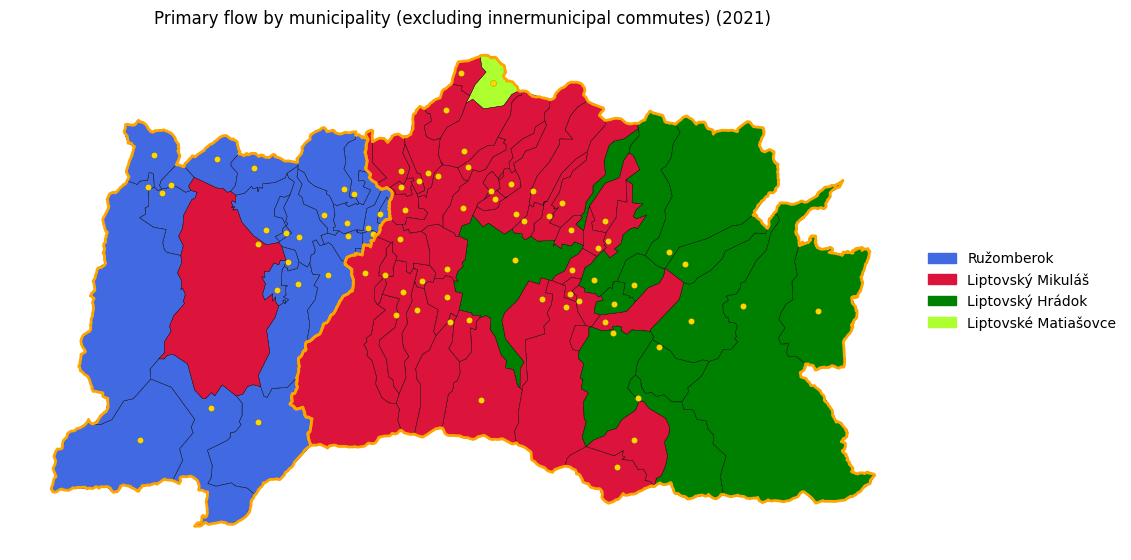

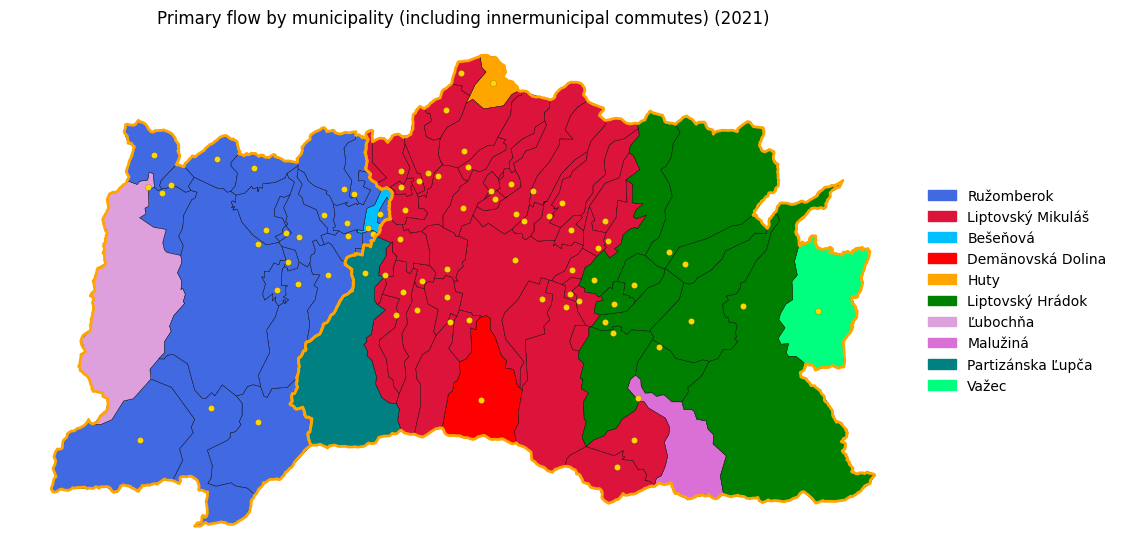

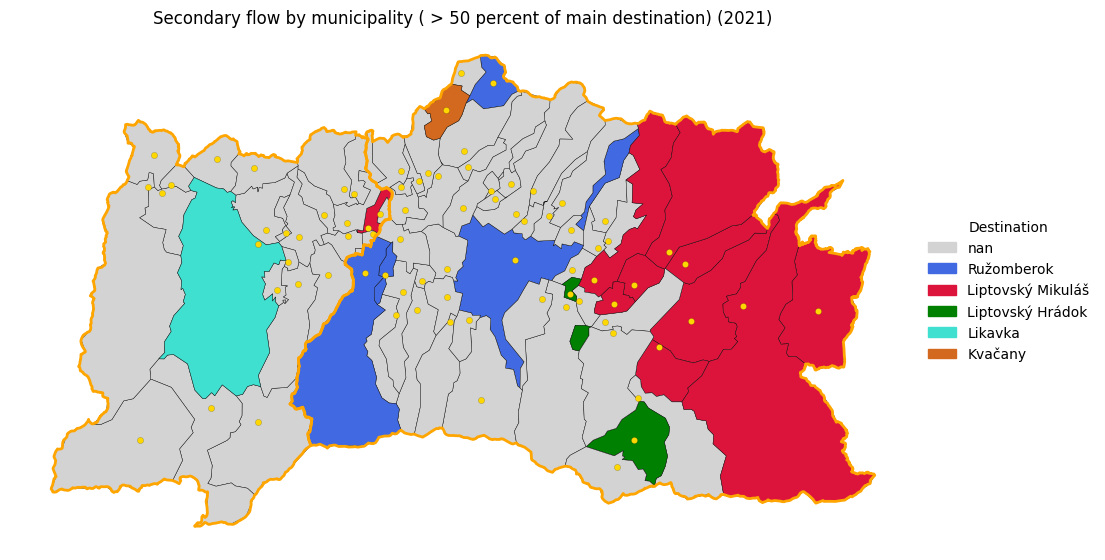

In [8]:
# (part 2)

plt.figure(figsize = (11.69, 8.27))
result.plot(
    ax = plt.gca(),
    color = result["color"].fillna("lightgray"),
    edgecolor = "black",
    linewidth = 0.3
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 20.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "orange",
    linewidth = 2.0
)

plt.legend(
    handles = legend_patches1,
    # title = "Destination",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False
)

plt.title("Primary flow by municipality (excluding innermunicipal commutes) (2021)")

plt.axis(False)

# plt.savefig("../result_maps/popular/2021_most_popular.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()



plt.figure(figsize = (11.69, 8.27))
result2.plot(
    ax = plt.gca(),
    color = result2["color"].fillna("lightgray"),
    edgecolor = "black",
    linewidth = 0.3
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 20.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "orange",
    linewidth = 2.0
)

plt.legend(
    handles = legend_patches2,
    # title = "Destination",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False
)

plt.title("Primary flow by municipality (including innermunicipal commutes) (2021)")

plt.axis(False)

# plt.savefig("../result_maps/popular/2021_most_popular_all.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()


plt.figure(figsize = (11.69, 8.27))
result3.plot(
    ax = plt.gca(),
    color = result3["color"].fillna("lightgray"),
    edgecolor = "black",
    linewidth = 0.3
)
obce_gdf.plot(
    ax = plt.gca(),
    color = "gold",
    markersize = 20.0,
    edgecolor = "black",
    linewidth = 0.1
)
okresy.plot(
    ax = plt.gca(),
    color = "none",
    edgecolor = "orange",
    linewidth = 2.0
)

plt.legend(
    handles = legend_patches3,
    title = "Destination",
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = False,
    # labelspacing = 1.25
)
plt.title("Secondary flow by municipality ( > 50 percent of main destination) (2021)")

plt.axis(False)
# plt.suptitle("Daily commuting patterns in Liptov region in 2021")
# plt.savefig("../result_maps/popular/2021_second_most_popular_50.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

   Unnamed: 0   obecA   obecB  pocet  okresA  okresB obecA_nazov  \
0           1  507300  507300     18  SK0318  SK0318   Ivachnová   
1           2  507300  507407      1  SK0318  SK0318   Ivachnová   
2           3  507300  510262     10  SK0318  SK0315   Ivachnová   
3           4  507300  510301      6  SK0318  SK0318   Ivachnová   
4           5  507300  510386      1  SK0318  SK0315   Ivachnová   

         obecB_nazov kod_start      start_x       start_y kod_dest  \
0          Ivachnová    507300  -395493.798  -1190259.070   507300   
1              Turík    507300  -395493.798  -1190259.070   507407   
2  Liptovský Mikuláš    507300  -395493.798  -1190259.070   510262   
3           Bešeňová    507300  -395493.798  -1190259.070   510301   
4  Demänovská Dolina    507300  -395493.798  -1190259.070   510386   

         end_x         end_y                         geometry  
0  -395493.798  -1190259.070  POINT (-395493.798 -1190259.07)  
1  -397590.562  -1188467.760  POINT (-3954

<Figure size 827x1169 with 0 Axes>

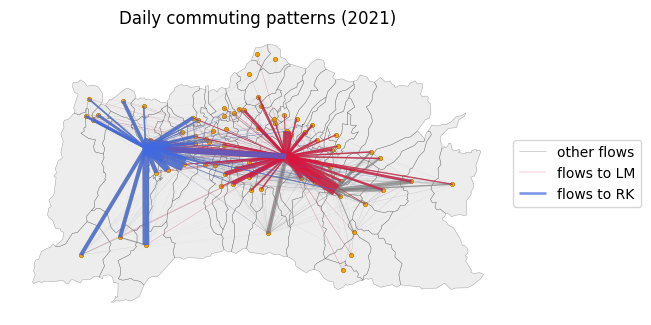

In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib .patches import Patch, Rectangle
from shapely.geometry import Point
from shapely.geometry import LineString

f = pd.read_csv(r"../data/sodb_2021_dochadzka_denne_lm_rk.csv", encoding="windows-1250")

obce = gpd.read_file(r"../data/liptov_obce.csv", encoding = "windows-1250")

f["obecA"] = f["obecA"].astype(str)
f["obecB"] = f["obecB"].astype(str)
obce["kod"] = obce["kod"].astype(str)
f = f.merge(
    obce[["kod", "x", "y"]],
    left_on = "obecA",
    right_on = "kod",
    how = "left"
).rename(columns={"x": "start_x", "y": "start_y", "kod": "kod_start"})

f = f.merge(
    obce[["kod", "x", "y"]],
    left_on = "obecB",
    right_on = "kod",
    how = "left"
).rename(columns={"x": "end_x", "y": "end_y", "kod": "kod_dest"})
commuting_gdf = gpd.GeoDataFrame(
    f,
    geometry=[Point(xy) for xy in zip(f["start_x"], f["start_y"])],
    crs="EPSG:5514"
)
print(commuting_gdf.head())

background = gpd.read_file(r"../data/geo/liptov.shp")
# flows_selected = f[f["kod_dest"].isin(["510262", "510998"])].copy()

# flows_selected["geometry"] = flows_selected.apply(
#     lambda row: LineString([(row["start_x"], row["start_y"]), (row["end_x"], row["end_y"])]),
#     axis = 1
# )
f["geometry"] = f.apply(
    lambda row: LineString([(row["start_x"], row["start_y"]), (row["end_x"], row["end_y"])]),
    axis = 1
)
line_gdf = gpd.GeoDataFrame(f, geometry = "geometry", crs="EPSG:5514")

flows_510262 = line_gdf[line_gdf["kod_dest"] == "510262"]
flows_510998 = line_gdf[line_gdf["kod_dest"] == "510998"]
flows_other = line_gdf
plt.figure(figsize = (8.27, 11.69))

ax = background.plot(
    alpha = 0.4,
    edgecolor = "black",
    color = "lightgray",
    linewidth = 0.3
)
flows_other.plot(
    ax = ax,
    linewidth = flows_other["pocet"]/50,
    alpha = 0.7,
    color = "grey",
    label = "other flows"
)
flows_510262.plot(
    ax = ax,
    linewidth = flows_510262["pocet"]/50,
    alpha = 0.7,
    color = "crimson",
    label = "flows to LM"
)

flows_510998.plot(
    ax = ax,
    linewidth = flows_510998["pocet"]/50,
    alpha = 0.7,
    color = "royalblue",
    label = "flows to RK"
)

obce_gdf.plot(
    ax = plt.gca(),
    color = "orange",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
plt.legend(
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = True
)

plt.title("Daily commuting patterns (2021)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis(False)

plt.grid(False)

obce_gdf.plot(
    ax = plt.gca(),
    color = "orange",
    markersize = 10.0,
    edgecolor = "black",
    linewidth = 0.1
)
plt.legend(
    loc = "center left",
    bbox_to_anchor = (1, 0.5),
    frameon = True
)

plt.title("Daily commuting patterns (2021)")
plt.axis(False)
plt.grid(False)

# plt.savefig("../result_maps/flows/LM_RK_flows_2021.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()

<Figure size 827x1169 with 0 Axes>

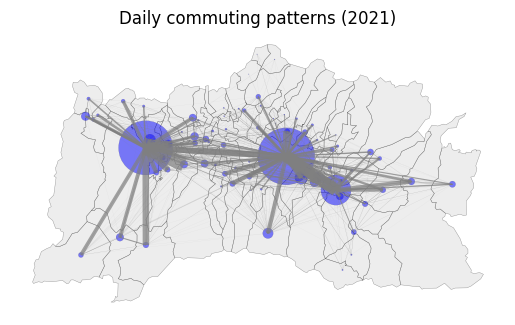

In [10]:
plt.figure(figsize = (8.27, 11.69))

ax = background.plot(
    alpha = 0.4,
    edgecolor = "black",
    color = "lightgray",
    linewidth = 0.3
)

flows_other.plot(
    ax = ax,
    linewidth = flows_other["pocet"]/50,
    alpha = 0.7,
    color = "grey",
    label = "other flows"
)
obce_gdf.plot(
    ax = ax,
    color = "blue",
    markersize = obce_gdf["pocet"]/obce_gdf["pocet"].idxmax()*10,
    alpha = 0.5,
    edgecolor = "black",
    linewidth = 0.1
)
plt.title("Daily commuting patterns (2021)")
plt.axis(False)
plt.grid(False)

# plt.savefig("../result_maps/flows/all_LM_RK_flows_2021.pdf", format = "pdf", dpi = 300, bbox_inches = "tight")
plt.show()